In [1]:
# import statements
import numpy as np
import xarray as xr
import glob
import random
import cartopy.io.shapereader as shpreader
import shapely.geometry as sgeom
from shapely.ops import unary_union
from shapely.prepared import prep
import sys
import matplotlib.pyplot as plt
import PolarTestingTrainingSplit_CV
from matplotlib.colors import LinearSegmentedColormap


# Get names of models in which we are testing on
path_to_data = '/home/disk/pna2/aodhan/SurfaceTrendLearning/PoChedleyEtAl2022/TASmaps/*_TrendMaps.nc'
ModelNames = [i[70:-16] for i in glob.glob(path_to_data)]

# Get observational data
observational_trends = glob.glob('/home/disk/p/aodhan/SurfaceTrendLearing/TropicalTASApplication/TASObsTrends/*.npy')
observational_trend_maps = [np.load(observational_trends[i]) for i in range(0,len(observational_trends))]
latitudes = np.linspace(-88.75,88.75,72)
weights = np.cos(np.deg2rad(latitudes)) # these will be used to weight predictors
observational_trend_maps_weighted = np.multiply(observational_trend_maps, weights[np.newaxis,:,np.newaxis])
observational_trend_maps_reshaped = np.reshape(observational_trend_maps_weighted, (3, 72*144))

# Create Custom Color Map
colors = np.array([(22,98,248), (48,141,250), (71,172,251), (100,201,252), (129,222,253),(162,240,254), (215,249,253), (255,255,255), 
                   (255,255,255), (255,249,217), (247,236,155), (254,221,128), (254,202,100), (255,173,71), (252,142,42), (255,101,15)])/255
custom_cmap = LinearSegmentedColormap.from_list('cmap', colors)

# Do CV train-test-split 
TrainingPredictorData, TrainingTargetData, TestingPredictorData, TestingTargetData, TestingTotalTrend = PolarTestingTrainingSplit_CV.training_testing_split(path_to_data)


In [4]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers
from sklearn.cross_decomposition import PLSRegression
from scipy import stats
import tensorflow as tf

# Set the seed for the random number generator
tf.random.set_seed(0)


# iterate over all CV folds (there should be eqaul number of CV folds as models)
NameValidatationPredictions = []
gistemp_predictions = []
era5_predictions = []
hadcrut_predictions = []
validations = []
predictions = []
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=10)# restore_best_weights=True)

for model_idx in range(len(ModelNames)):
    
    # Reshape target and predictor data for model
    TrainingTargetDataShape = np.shape(TrainingTargetData[model_idx])
    TestinTargetDataShape = np.shape(TestingTargetData[model_idx])
    TrainingTargetDataReshaped = np.reshape(TrainingTargetData[model_idx], (TrainingTargetDataShape[0], TrainingTargetDataShape[1]*TrainingTargetDataShape[2]))
    TestingTargetDataReshaped = np.reshape(TestingTargetData[model_idx], (TestinTargetDataShape[0], TestinTargetDataShape[1]*TestinTargetDataShape[2]))

    # Model Design
    pls = PLSRegression(n_components=6)
    
    # Train model
    TrainingTargetDataReshaped = np.transpose([TrainingTargetDataReshaped[:,0]])#, TrainingTargetDataReshaped[:,3]])

    #TrainingTargetDataReshaped = TrainingTargetDataReshaped[:,0]
    pls_model = pls.fit(TrainingPredictorData[model_idx], TrainingTargetDataReshaped)
    X_train_pls = pls.transform(TrainingPredictorData[model_idx])
    X_test_pls = pls.transform(TestingPredictorData[model_idx])


    model = Sequential()
    model.add(Dense(units=14, input_shape=(X_train_pls.shape[1],), activation='relu'))
    #model.add(Dense(units=1, activation='linear'))
    model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(learning_rate=.00001))

    history = model.fit(X_train_pls, TrainingTargetDataReshaped, epochs=250, batch_size=32, verbose=False, 
                        callbacks=[callback])

    # Predict using trained model
    Y_pred = model.predict(X_test_pls)

    # Apply trained model to observations
    #Y_pred_Gistemp = MLmodel.predict(observational_trend_maps_reshaped[0].reshape(1, -1))
    #Y_pred_ERA5 = MLmodel.predict(observational_trend_maps_reshaped[1].reshape(1, -1))
    #Y_pred_HadCrut = MLmodel.predict(observational_trend_maps_reshaped[2].reshape(1, -1))
    
    # Save output for plotting
    NameValidatationPredictions.append([ModelNames[model_idx], TestingTargetDataReshaped, Y_pred])
    #gistemp_predictions.append(Y_pred_Gistemp)
    #era5_predictions.append(Y_pred_ERA5)
    #hadcrut_predictions.append(Y_pred_HadCrut)
    validations.append([TestingTargetDataReshaped[:,0]])
    predictions.append(Y_pred)
    print(ModelNames[model_idx])
    true_vals = [TestingTargetDataReshaped[:,0]]
    #nat_val = true_vals[0]
    for_val = true_vals[0]
    print('LOO Correlation: ', stats.pearsonr(for_val, Y_pred.T[0])[0])
    print('LOO mea: ', np.nanmean(np.abs((np.array(for_val) - np.array(Y_pred.T[0])))))
    print('training mse: ', history.history['loss'][-1])
    #print('validation mse: ', history.history['val_loss'][-1])
    print('LOO mse: ', np.nanmean((np.array(for_val) - np.array(Y_pred.T[0]))**2))
    print('N epochs: ', len(history.history['loss']))
    print('_______________________')


2/2 [==============================] - 0s 5ms/step
ACCESS_ESM1_5_
LOO Correlation:  nan
LOO mea:  0.029865671
training mse:  0.0015838389517739415
LOO mse:  0.0015101148
N epochs:  250
_______________________


/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


2/2 [==============================] - 0s 8ms/step
CESM2_
LOO Correlation:  -0.36134213887847044
LOO mea:  0.18779565
training mse:  0.019754907116293907
LOO mse:  0.11287433
N epochs:  250
_______________________
1/1 [==============================] - 0s 53ms/step
CNRM_CM6_1_
LOO Correlation:  nan
LOO mea:  0.017289782
training mse:  0.02055801823735237
LOO mse:  0.0003968684
N epochs:  250
_______________________


/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


2/2 [==============================] - 0s 2ms/step
CanESM5_
LOO Correlation:  nan
LOO mea:  0.025302088
training mse:  0.0011624762555584311
LOO mse:  0.0009900421
N epochs:  250
_______________________


/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


1/1 [==============================] - 0s 38ms/step
GISS_E2_1_G_
LOO Correlation:  nan
LOO mea:  0.016750475
training mse:  0.0010097125777974725
LOO mse:  0.00033738627
N epochs:  250
_______________________


/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


1/1 [==============================] - 0s 30ms/step
IPSL_CM6A_LR_
LOO Correlation:  nan
LOO mea:  0.021430358
training mse:  0.06009132042527199
LOO mse:  0.0006836385
N epochs:  250
_______________________


/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


1/1 [==============================] - 0s 32ms/step
MIROC_ES2L_
LOO Correlation:  nan
LOO mea:  0.027349321
training mse:  0.0030501813162118196
LOO mse:  0.0011205907
N epochs:  250
_______________________


/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


2/2 [==============================] - 0s 3ms/step
MIROC6_
LOO Correlation:  nan
LOO mea:  0.027505126
training mse:  0.07888364791870117
LOO mse:  0.0014713028
N epochs:  250
_______________________


/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


1/1 [==============================] - 0s 123ms/step
NorCPM1_
LOO Correlation:  0.43487246875043595
LOO mea:  0.1481057
training mse:  0.016165878623723984
LOO mse:  0.10185823
N epochs:  250
_______________________
1/1 [==============================] - 0s 53ms/step
UKESM1_0_LL_
LOO Correlation:  nan
LOO mea:  0.02881906
training mse:  0.000984980957582593
LOO mse:  0.0010889155
N epochs:  250
_______________________


/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


1/1 [==============================] - 0s 28ms/step
GISS_E2_1_H_
LOO Correlation:  nan
LOO mea:  0.024616506
training mse:  0.001849525491707027
LOO mse:  0.00083527074
N epochs:  250
_______________________


/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


1/1 [==============================] - 0s 34ms/step
INM_CM5_0_
LOO Correlation:  nan
LOO mea:  0.012219494
training mse:  0.001775283133611083
LOO mse:  0.00020440319
N epochs:  250
_______________________


/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [6]:
true_values = []
prediction_data = []
for x in range(14):
    for y in range(0, len(validations[x][0].T)):
        true_values.append(validations[x][0].T[y])
        prediction_data.append(predictions[x][y][0])
        
print(stats.pearsonr(true_values, prediction_data)[0])
print(np.nanmean(np.abs((np.array(prediction_data) - np.array(true_values)))))

#plt.scatter(validations[2][0], predictions[2].flatten())


0.6843027180772152
0.023561941


In [7]:
true_values = []
prediction_data = []
for x in range(14):
    for y in range(0, len(validations[x][0].T)):
        true_values.append(validations[x][0].T[y])
        prediction_data.append(predictions[x][y][0])
        
print(stats.pearsonr(true_values, prediction_data)[0])
print(np.nanmean(np.abs((np.array(prediction_data) - np.array(true_values)))))

0.6908794290578346
0.019792316


In [15]:
#natural
gistemp_predictions = np.array(gistemp_predictions)
era5_predictions = np.array(era5_predictions)
hadcrut_predictions = np.array(hadcrut_predictions)
print(np.nanmean(gistemp_predictions[:,0,0]), np.nanmean(era5_predictions[:,0,0]), np.nanmean(hadcrut_predictions[:,0,0]))

-0.07349403113181456 -0.04987738579426813 -0.055126083126221144


/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykern

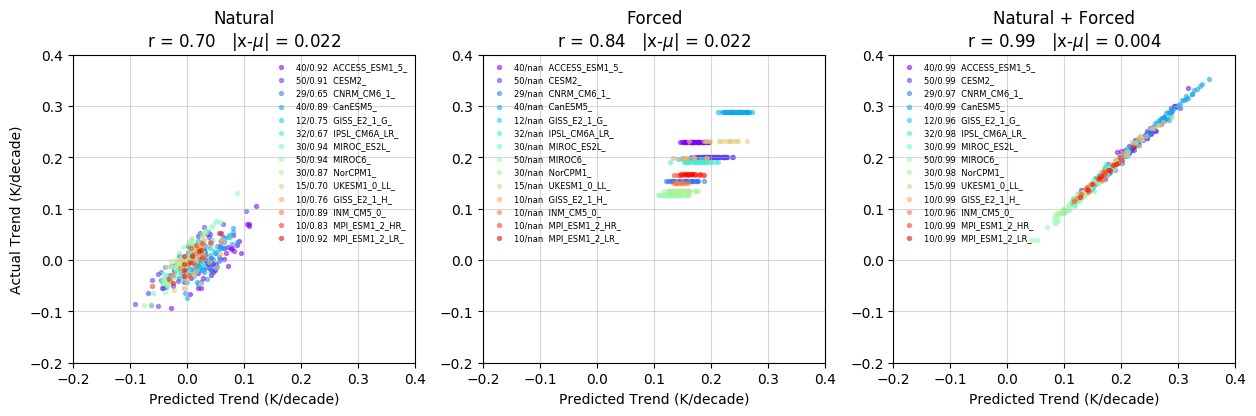

In [3]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
import matplotlib.cm as cm

####################################################################################
colors = cm.rainbow(np.linspace(0, 1, 14))
NatValAndPred = []
ForValAndPred = []
TotValAndPred = []
for model_idx in range(len(NameValidatationPredictions)):
    modelName = NameValidatationPredictions[model_idx][0]    
    ValidationData = NameValidatationPredictions[model_idx][1]
    PredictedData = NameValidatationPredictions[model_idx][2]
    TotalData = TestingTotalTrend[model_idx]
    N_ensembles = len(PredictedData)
    r_values = []
    for predictant_idx in range(3):
        axs_obj = axs[predictant_idx]

        # Natural Trend
        if predictant_idx == 0:
            val = ValidationData[:,0]
            pred = PredictedData[:,0]
            NatValAndPred.append([val, pred])
            axs_obj.set_ylabel('Actual Trend (K/decade)')

        # Forced Trend
        elif predictant_idx == 1:
            val = ValidationData[:,3]
            pred = PredictedData[:,1]
            ForValAndPred.append([val, pred])
        
        # Total Trend
        elif predictant_idx == 2:
            val = TotalData
            pred = PredictedData[:,0] + PredictedData[:,1]
            TotValAndPred.append([val, pred])

        #Plotting
        r = stats.pearsonr(val, pred)[0]
        label_id = str(N_ensembles) + '/' + str(r)[:4] + ' ' + ' ' + modelName
        
        axs_obj.scatter(pred, val, label=label_id, color=colors[model_idx], s=8, alpha=0.5)
        axs_obj.legend(loc=0, prop={'size': 6}, frameon=False)
        axs_obj.set_ylim(-0.2,0.4)
        axs_obj.set_xlim(-0.2,0.4)
        axs_obj.set_xlabel('Predicted Trend (K/decade)')
        axs_obj.grid(alpha=0.5)

# Give scores across all models and ensemble members
NatValAndPred = np.array(NatValAndPred)
ForValAndPred = np.array(ForValAndPred)
TotValAndPred = np.array(TotValAndPred)
AllModelAllEnsemble = [NatValAndPred, ForValAndPred, TotValAndPred]
titles = ['Natural', 'Forced', 'Natural + Forced']
for i in range(3):
    axs_obj = axs[i]
    val_pred_data = AllModelAllEnsemble[i]
    vals = list(np.concatenate(val_pred_data[:,0]).flat)
    preds = list(np.concatenate(val_pred_data[:,1]).flat)
    allsimulation_r = stats.pearsonr(vals, preds)[0]
    avg_deviation = np.nanmean(np.abs((np.array(vals) - np.array(preds))))
    axs_obj.set_title(titles[i] + '\nr = ' + str(allsimulation_r)[:4] + '   |x-$\mu$| = ' + str(avg_deviation)[:5])

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

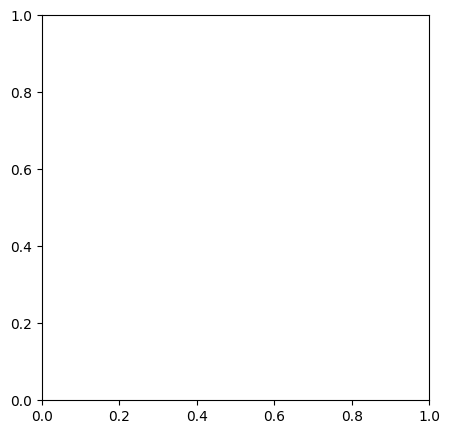

In [9]:
fig, axs_obj = plt.subplots(1, 1, figsize=(5, 5))
import matplotlib.cm as cm

####################################################################################
colors = cm.rainbow(np.linspace(0, 1, 20))
all_r_values = []
for model_idx in range(len(NameValidatationPredictions)):
    modelName = NameValidatationPredictions[model_idx][0]
    ValidationData = TestingTotalTrend[model_idx]
    #ValidationData = NameValidatationPredictions[model_idx][1]
    PredictedData = NameValidatationPredictions[model_idx][2]
    N_ensembles = len(PredictedData)
    
    r_values = []
    for predictant_idx in range(1):
        #val = ValidationData[:,0]
        val = ValidationData
        pred = PredictedData[:,0] + PredictedData[:,3]
        r = stats.pearsonr(val, pred)[0]
        r_values.append(r)
        
        label_id = str(N_ensembles) + '/' + str(r)[:4] + ' ' + ' ' + modelName
        axs_obj.scatter(pred, val, label=label_id, color=colors[model_idx], s=8, alpha=0.5)
        axs_obj.legend(loc=0, prop={'size': 6}, frameon=False)

        axs_obj.set_ylim(-1,2)
        axs_obj.set_xlim(-1,2)
        axs_obj.set_ylabel('Trend (K/decade)')
        axs_obj.set_xlabel('Predicted Natural + Predicted Forced Trend (K/decade)')
    all_r_values.append(r_values)
axs_obj.set_title('PLS Regression: r = ' + str(np.nanmean(all_r_values))[:4])


In [7]:
print('Natural: ', np.nanmean(ERA5_predictions, axis=0)[0,0])
print('Forced: ', np.nanmean(ERA5_predictions, axis=0)[0,3])
print('Sum: ', np.nanmean(ERA5_predictions, axis=0)[0,0] + np.nanmean(ERA5_predictions, axis=0)[0,3])

NameError: name 'ERA5_predictions' is not defined

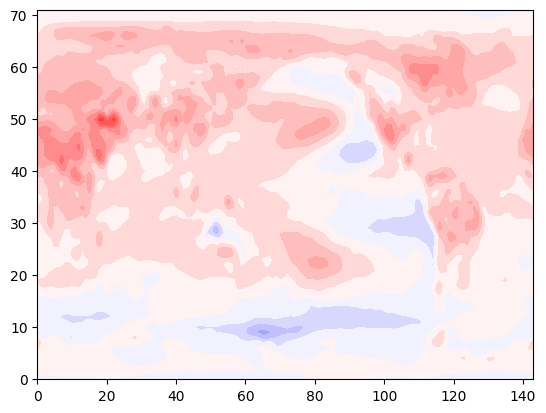

In [5]:
plt.contourf(np.reshape(observational_trend_maps_reshaped[1], (72,144)), cmap='bwr', levels=np.linspace(-1,1,21), extend='both')

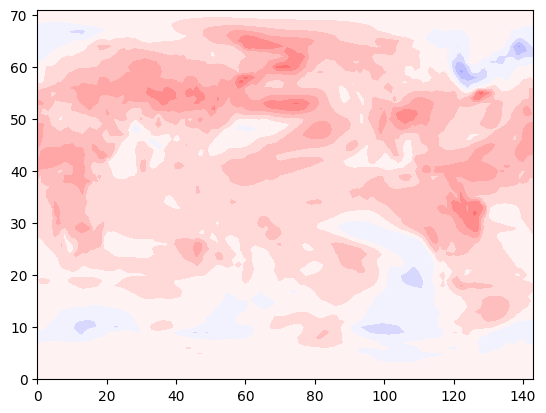

In [6]:
plt.contourf(np.reshape(test_model_data, (72,144)), cmap='bwr', levels=np.linspace(-1,1,21), extend='both')

In [7]:
def model_ensemble_reshaper(trends):
    """
    Takes a given models testing or trainging data and 
    reshapes it so that timeperiods from different ensembles
    of a given model are treated equally.
    """
    trends = trends[:,8:,:,:]
    print(np.shape(trends))
    reshaped_trends = np.reshape(trends, (np.shape(trends)[0]*np.shape(trends)[1], 72,144))
    return(reshaped_trends)

def train_test_splitting(xarray_file):
    """
    Split model data into train and testing. 10 ensemble 
    members for each model are used for training as to 
    not over weight a given model. All remaining ensemble 
    members are used for testing.
    """
    # Find number of ensembles and random indicies of testing versus training ensembels
    Nensembles = len(xarray_file.ensemble_member)
    ensemble_train_indices = random.sample(range(0,Nensembles),10)

    # Select natural and forced trends as well as the training and testing data
    trend_data = xarray_file.to_array()[0]
    #NatTrendsTrain = trend_data[ensemble_train_indices,0].to_numpy()
    #ForTrendsTrain = trend_data[ensemble_train_indices,1].to_numpy()
    NatTrendsTrain = trend_data[:,0].to_numpy()
    ForTrendsTrain = trend_data[:,1].to_numpy()

    return(NatTrendsTrain, ForTrendsTrain)

def training_testing_split(path_to_data):
    # set path to data
    ModelDataFiles = glob.glob(path_to_data)

    # select lat bounds used for subsection of globe
    latbounds = [28,44]
    # create land sea mask
    sample_grid = xr.open_dataset(ModelDataFiles[0]) 
    latitudes = sample_grid.Lat.to_numpy()
    longitudes = sample_grid.Lon.to_numpy() - 180
    """land_sea_mask = []
    for x in longitudes:
        land_sea_mask_at_latitude = []
        for y in latitudes:
            land_sea_mask_at_latitude.append(is_land(x, y))
        land_sea_mask.append(land_sea_mask_at_latitude)
    land_sea_mask = np.transpose(land_sea_mask)
    land_sea_mask = np.concatenate([land_sea_mask[:,72:], land_sea_mask[:,:72]], axis=1)"""
    
    TrainingPredictorData = []
    TrainingTargetData = []
    TestingPredictorData = []
    TestingTargetData = []
    TestingTotalTrend = []
    for x in range(len(ModelDataFiles)):
        TrainingModelDataFiles = ModelDataFiles[:x] + ModelDataFiles[x+1:]
        TestingModelDataFiles = ModelDataFiles[x] 

        # First, take care of training data
        #########################--------Training--------#########################
        OneCVTrainingPredictorData = []
        OneCVTrainingTargetData = []
        for datafile in TrainingModelDataFiles:
            xarray_file = xr.open_dataset(datafile)
            
            # find training data for natural and forced trends
            NatTrendsTrain, ForTrendsTrain = train_test_splitting(xarray_file)

            # reshape trends so that trend maps from different time periods and ensembles are treated equal
            NatTrendsTrain = model_ensemble_reshaper(NatTrendsTrain)
            ForTrendsTrain = model_ensemble_reshaper(ForTrendsTrain)

path_to_data = '/home/disk/pna2/aodhan/SurfaceTrendLearning/PoChedleyEtAl2022/TASmaps/*_TrendMaps.nc'
training_testing_split(path_to_data)

(50, 18, 72, 144)
(50, 18, 72, 144)
(29, 18, 72, 144)
(29, 18, 72, 144)
(40, 18, 72, 144)
(40, 18, 72, 144)
(12, 18, 72, 144)
(12, 18, 72, 144)
(32, 18, 72, 144)
(32, 18, 72, 144)
(30, 18, 72, 144)
(30, 18, 72, 144)
(50, 18, 72, 144)
(50, 18, 72, 144)
(30, 18, 72, 144)
(30, 18, 72, 144)
(15, 18, 72, 144)
(15, 18, 72, 144)
(10, 18, 72, 144)
(10, 18, 72, 144)
(10, 18, 72, 144)
(10, 18, 72, 144)
(10, 18, 72, 144)
(10, 18, 72, 144)
(10, 18, 72, 144)
(10, 18, 72, 144)
(40, 18, 72, 144)
(40, 18, 72, 144)
(29, 18, 72, 144)
(29, 18, 72, 144)
(40, 18, 72, 144)
(40, 18, 72, 144)
(12, 18, 72, 144)
(12, 18, 72, 144)
(32, 18, 72, 144)
(32, 18, 72, 144)
(30, 18, 72, 144)
(30, 18, 72, 144)
(50, 18, 72, 144)
(50, 18, 72, 144)
(30, 18, 72, 144)
(30, 18, 72, 144)
(15, 18, 72, 144)
(15, 18, 72, 144)
(10, 18, 72, 144)
(10, 18, 72, 144)
(10, 18, 72, 144)
(10, 18, 72, 144)
(10, 18, 72, 144)
(10, 18, 72, 144)
(10, 18, 72, 144)
(10, 18, 72, 144)
(40, 18, 72, 144)
(40, 18, 72, 144)
(50, 18, 72, 144)
(50, 18, 7